# ProfAIling project

In [1]:
# Required libraries.
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import spacy
import string
import nltk
from nltk.corpus import stopwords
from spacy import tokenizer
from spacy.lang.en import English
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import seaborn as sns
import re
from bs4 import BeautifulSoup
import unicodedata
import pickle
from nltk.probability import FreqDist

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['font.family'] = 'Serif'
our_col = ['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c']

In [4]:
# Import data.
train = pd.read_json( 'C:/Users/susan/Documents/DS/SL-Final-Project/train.json' )

# Let's have a look at out data.
print(train.head(15))
print('')
print(train.shape)

                                                 post  age  gender
0                           ooh shiny new commenting!   16  female
1   so wuts up? today i had the parade. suked. but...   14    male
2   i don't know about anyone else anymore, but i'...   24  female
3   urlLink    another roof-top sunset  Posted by ...   24    male
4   gawd i luv my nanny!  she's absolutely the gre...   23  female
5   7._ Km, 39:19.4, Partly cloudy -4C, 6 km wind ...   41    male
6   well, it's still summer vacation ':-( and I wi...   13    male
7   Yes! School is out for summer! The sun is shin...   17  female
8   urlLink Electric Venom:A Venomous Love Note   ...   34  female
9   Boring mission. We had another routine presenc...   25    male
10  I passed. Details not yet available. But I pas...   23    male
11  Cel, this one's for you.  *Ahem*  urlLink Heh ...   27  female
12                                           572.8!!!   27    male
13  Eight and a half hours, at a laundromat. Gah, ...   17    

In [5]:
# Checking missin values.
train.isna().sum()

post      0
age       0
gender    0
dtype: int64

# Exploratory Data Analysis

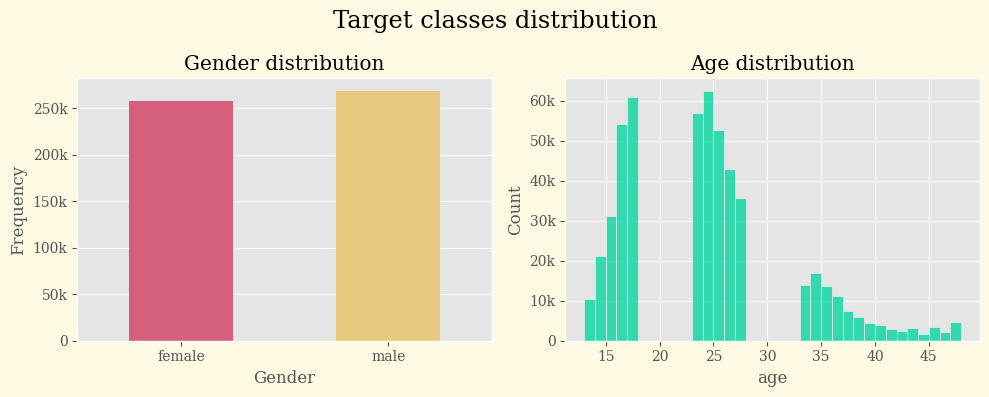

In [35]:
fig, axes = plt.subplots(1,2, figsize = (10,4),facecolor='#FDF9E2')
fig_sex = sns.countplot(data=train, x='gender', palette = our_col, saturation=0.7, width=0.5, ax=axes[0])
fig_sex.set(title='Gender distribution', xlabel='Gender', ylabel='Frequency',
             yticklabels=(['0','50k','100k','150k','200k','250k']))
fig_age = sns.histplot(train, x = "age", color=our_col[2], alpha = 0.8, binwidth=1, ax = axes[1])
fig_age.set(title="Age distribution",yticklabels=(['0','10k','20k','30k','40k','50k','60k']))
fig.suptitle("Target classes distribution",fontsize =  'xx-large')
plt.tight_layout()
plt.savefig("plots/PP_targetclass.png")


## 1. Counts and lengths

### Character Count

In [19]:
# New column for the length of the posts.
train['length'] = train['post'].apply(len)

In [12]:
np.quantile(train['length'],0.85)

2018.0

In [45]:
# Cut in classes 
train['age_class'] = pd.cut(
        train["age"],
        bins=[12, 18, 28, 50],
        labels=[0, 1, 2]
    ).astype("int")
#check
train["age_class"].value_counts()

1    239520
0    169678
2     94699
Name: age_class, dtype: int64

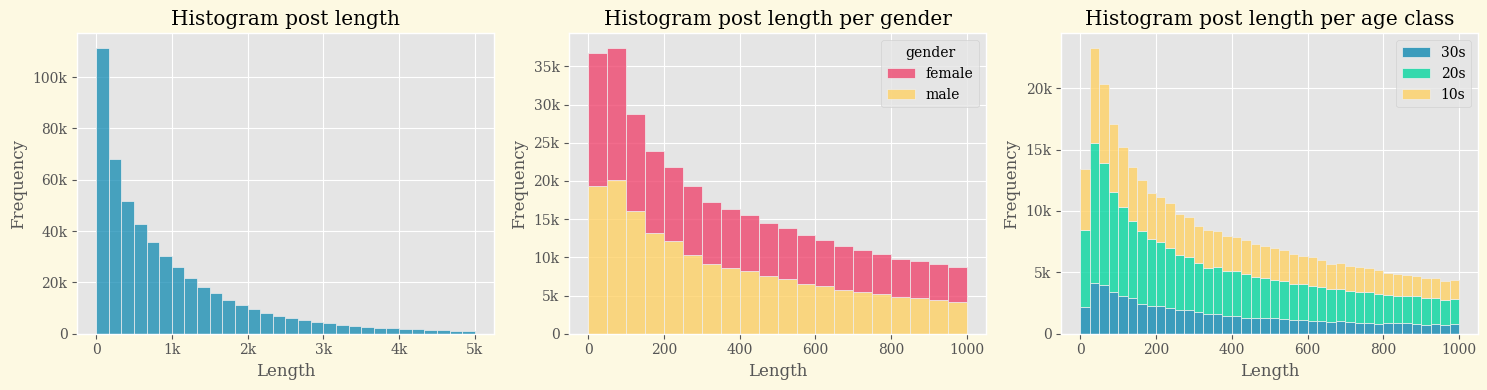

In [37]:
fig, axes = plt.subplots(1,3, figsize = (15,4),facecolor='#FDF9E2')
fig_len = sns.histplot(train[train.length <= 5000], x = "length", bins = 30, color=our_col[3], ax=axes[0])
#, stat = "frequency" per avere le frequenze relative e non assolute
fig_len.set(title='Histogram post length', xlabel='Length', ylabel='Frequency',
         yticklabels=(['0','20k','40k','60k','80k','100k']), 
         xticklabels=(['0','0','1k','2k','3k','4k','5k'])
         )
fig_len_gen = sns.histplot(train[train.length <= 1000], x = "length",hue='gender', binwidth=50, palette=our_col[0:2], alpha = 0.8, multiple="stack", ax = axes[1])
#, stat = "frequency" per avere le frequenze relative e non assolute
fig_len_gen.set(title='Histogram post length per gender', xlabel='Length', ylabel='Frequency',
                yticklabels=(['0','5k','10k','15k','20k','25k','30k','35k']))

fig_len_age = sns.histplot(train[train.length <= 1000], x = "length",hue='age_class',binwidth=25, palette=our_col[1:4], alpha = 0.8, multiple="stack", ax = axes[2])
#, stat = "frequency" per avere le frequenze relative e non assolute
fig_len_age.set(title='Histogram post length per age class', xlabel='Length', ylabel='Frequency',
                yticklabels=(['0','5k','10k','15k','20k']))
plt.legend(labels=["30s","20s","10s"])
plt.tight_layout()
plt.savefig("plots/PP_postlength.png")


### Word Count

In [25]:
# Adding a new colums with the number of word for the number of words in every post.
# Different from Lenght because is not the numbers of characters.
train['word_count'] = train['post'].apply(lambda x: len(str(x).split()))
print(train[train['age_class']==0]['word_count'].mean()) # 12 - 17 tweets
print(train[train['age_class']==1]['word_count'].mean()) # 18 - 29 tweets
print(train[train['age_class']==2]['word_count'].mean()) # 29 - 50 tweets

190.02078228616386
205.92256015829452
215.80631364562117


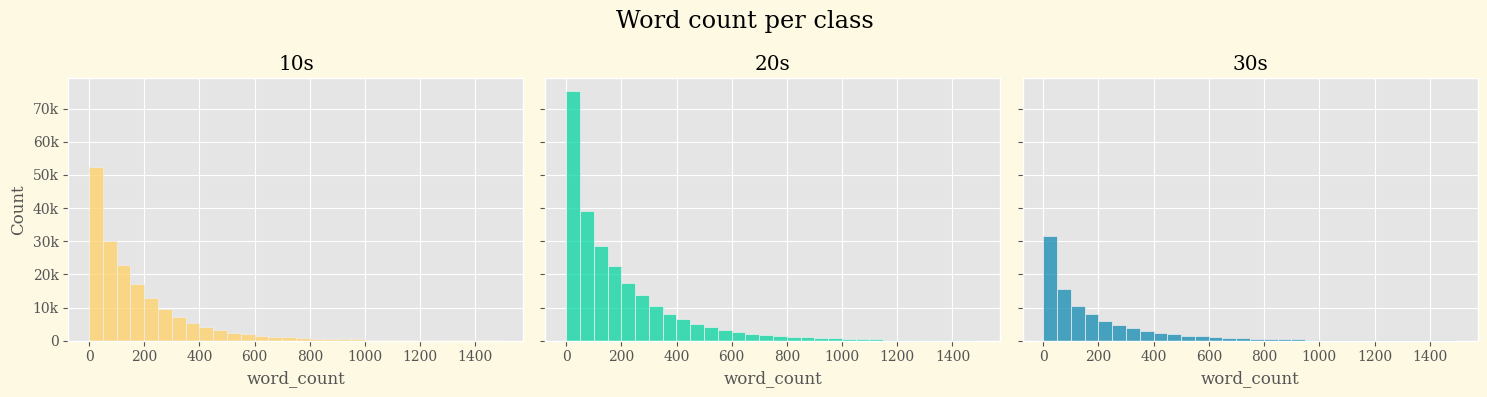

In [38]:
train[train.age_class==0]['word_count'].max() #115370 
train[train.age_class==1]['word_count'].max() #69208
train[train.age_class==2]['word_count'].max() #131169
#weeeel very big, maybe they are outliers...

# These histograms are only up to 1500 words because few tweets have more than this number but there are some tweet with a loooots of words.
fig, axes = plt.subplots(1,3, figsize = (15,4), sharey=True,facecolor='#FDF9E2')
fig_0 = sns.histplot(train[train.age_class==0][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[1], ax=axes[0]).set(title = "10s",yticklabels = (['0','10k','20k','30k','40k','50k','60k','70k']))
fig_1 = sns.histplot(train[train.age_class==1][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[2], ax=axes[1]).set(title = "20s")
fig_2 = sns.histplot(train[train.age_class==2][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[3], ax=axes[2]).set(title = "30s")
fig.suptitle("Word count per class",fontsize = "xx-large")
plt.tight_layout()
plt.savefig("plots/PP_word_count_perclass.png")

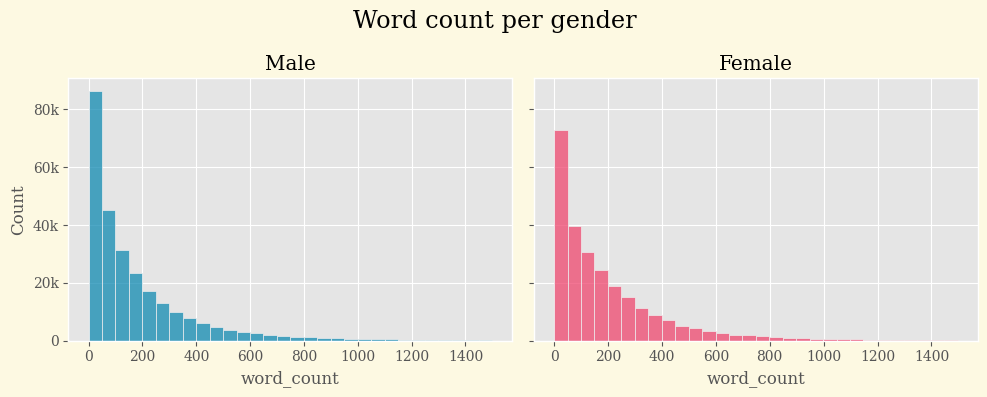

In [39]:
fig, axes = plt.subplots(1,2, figsize = (10,4), sharey=True,facecolor='#FDF9E2')
fig_0 = sns.histplot(train[train.gender == "male"][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[3], ax=axes[0]).set(title = "Male",yticklabels = (['0','20k','40k','60k','80k']))
fig_1 = sns.histplot(train[train.gender=="female"][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[0], ax=axes[1]).set(title = "Female")
fig.suptitle("Word count per gender",fontsize = "xx-large")
plt.savefig("plots/PP_word_count_perGender.png")
plt.tight_layout()

### Sentence Count

In [27]:
# Sentence counts
train["sent_count"] = train["post"].map(lambda x: len(sent_tokenize(x)))
# Average word length
train["avg_word_len"] = train["post"].map(lambda x: np.mean([len(w) for w in str(x).split()])).fillna(0)
# Average sentence length
train["avg_sent_len"] = train["post"].map(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)])).fillna(0)
#take ages to run (8 minutes ahahah)

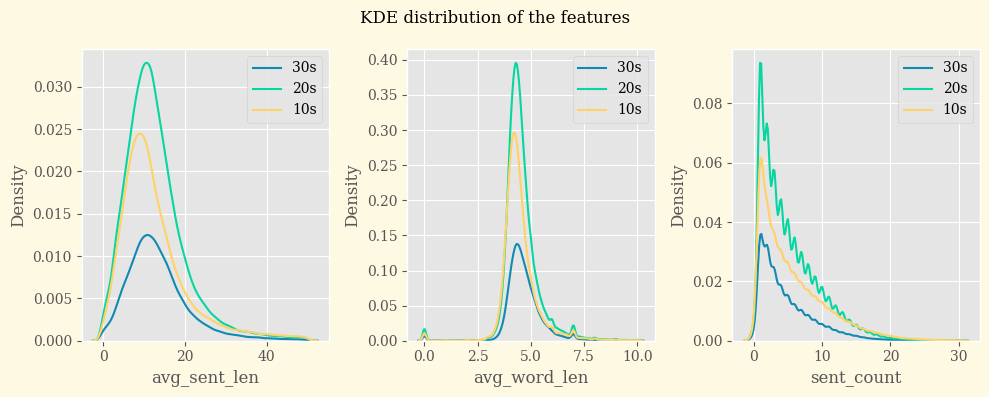

In [40]:
#Too many outliers, need less data.
train_small = train.loc[train["length"]<1000] #Almost all post are under 1000
train_small_sent_count = train_small[train_small.sent_count <= 30] # to make possible see the differences
train_small_avg_word = train_small[train_small.avg_word_len <= 10]
train_small_avg_sent = train_small[train_small.avg_sent_len <= 50]

# KDE plot
# (Kernel density estimate)
# KDE represents the data using a continuous probability density curve in one or more dimensions.
fig, axes = plt.subplots(figsize=(10,4), ncols=3, nrows=1,facecolor='#FDF9E2')
sns.kdeplot(data = train_small_avg_sent, x = "avg_sent_len", ax = axes[0], label = "Average sentence length", hue="age_class", palette = [our_col[1],our_col[2],our_col[3]])
axes[0].legend(labels=["30s", "20s", "10s"])
sns.kdeplot(data = train_small_avg_word, x = "avg_word_len", ax = axes[1], label = "Average word length", hue="age_class", palette = [our_col[1],our_col[2],our_col[3]])
axes[1].legend(labels=["30s", "20s", "10s"])
sns.kdeplot(data = train_small_sent_count, x = "sent_count", ax = axes[2], label = "Sentence count", hue="age_class", palette =  [our_col[1],our_col[2],our_col[3]])
axes[2].legend(labels=["30s", "20s", "10s"])
fig.suptitle("KDE distribution of the features")
plt.tight_layout()
plt.savefig("plots/PP_kde_perclass.png")

#15 sec to run

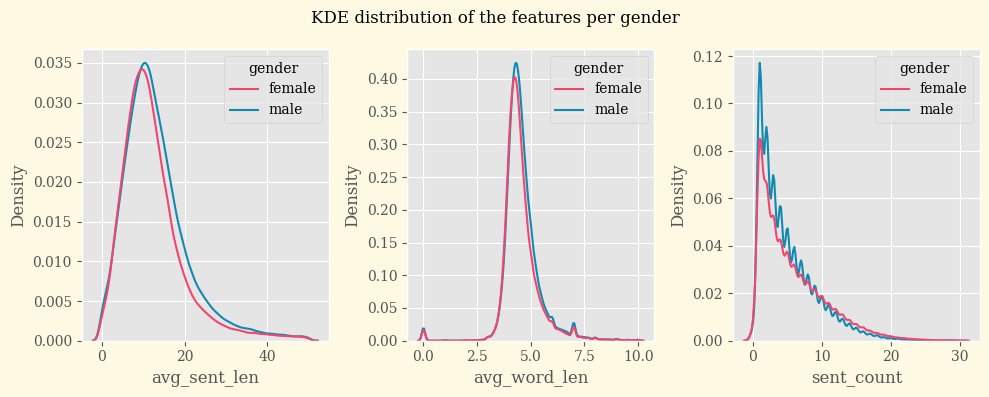

In [41]:
fig, axes = plt.subplots(figsize=(10,4), ncols=3, nrows=1,facecolor='#FDF9E2')

sns.kdeplot(data = train_small_avg_sent, x = "avg_sent_len", ax = axes[0], label = "Average sentence length", hue="gender", palette = [our_col[0],our_col[3]])
sns.kdeplot(data = train_small_avg_word, x = "avg_word_len", ax = axes[1], label = "Average word length", hue="gender", palette = [our_col[0],our_col[3]])
sns.kdeplot(data = train_small_sent_count, x = "sent_count", ax = axes[2], label = "Sentence count", hue="gender", palette = [our_col[0],our_col[3]])
fig.suptitle("KDE distribution of the features per gender")
plt.tight_layout()
plt.savefig("plots/PP_kde_perGender.png")

# EDA | Term Frequency Analysis

In [43]:
# It's necessary to read the preprocessed train created from the file embedding.ipynb
train = pd.read_pickle('train_clean_2.pkl')

In [16]:
train.head(5)

,post,age,gender
0,ooh shiny commenting,16,female
1,parade suked band battle kicked ass jims party...,14,male
2,anymore concerned everyday bold faced liar ahe...,24,female
3,roof sunset posted paul,24,male
4,love nanny absolutely greatest woman earth ner...,23,female


In [48]:
def most_common_words(train):
    corpus = [word for i in train["post"].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common()
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return words, frequency

class_0 = train[train.age_class == 0]
class_1 = train[train.age_class == 1]
class_2 = train[train.age_class == 2]

words_0,frequency_0 = most_common_words(class_0)
words_1,frequency_1 = most_common_words(class_1)
words_2,frequency_2 = most_common_words(class_2)

class_male = train[train.gender == "male"]
class_female = train[train.gender == "female"]

words_m,frequency_m = most_common_words(class_male)
words_f,frequency_f = most_common_words(class_female)


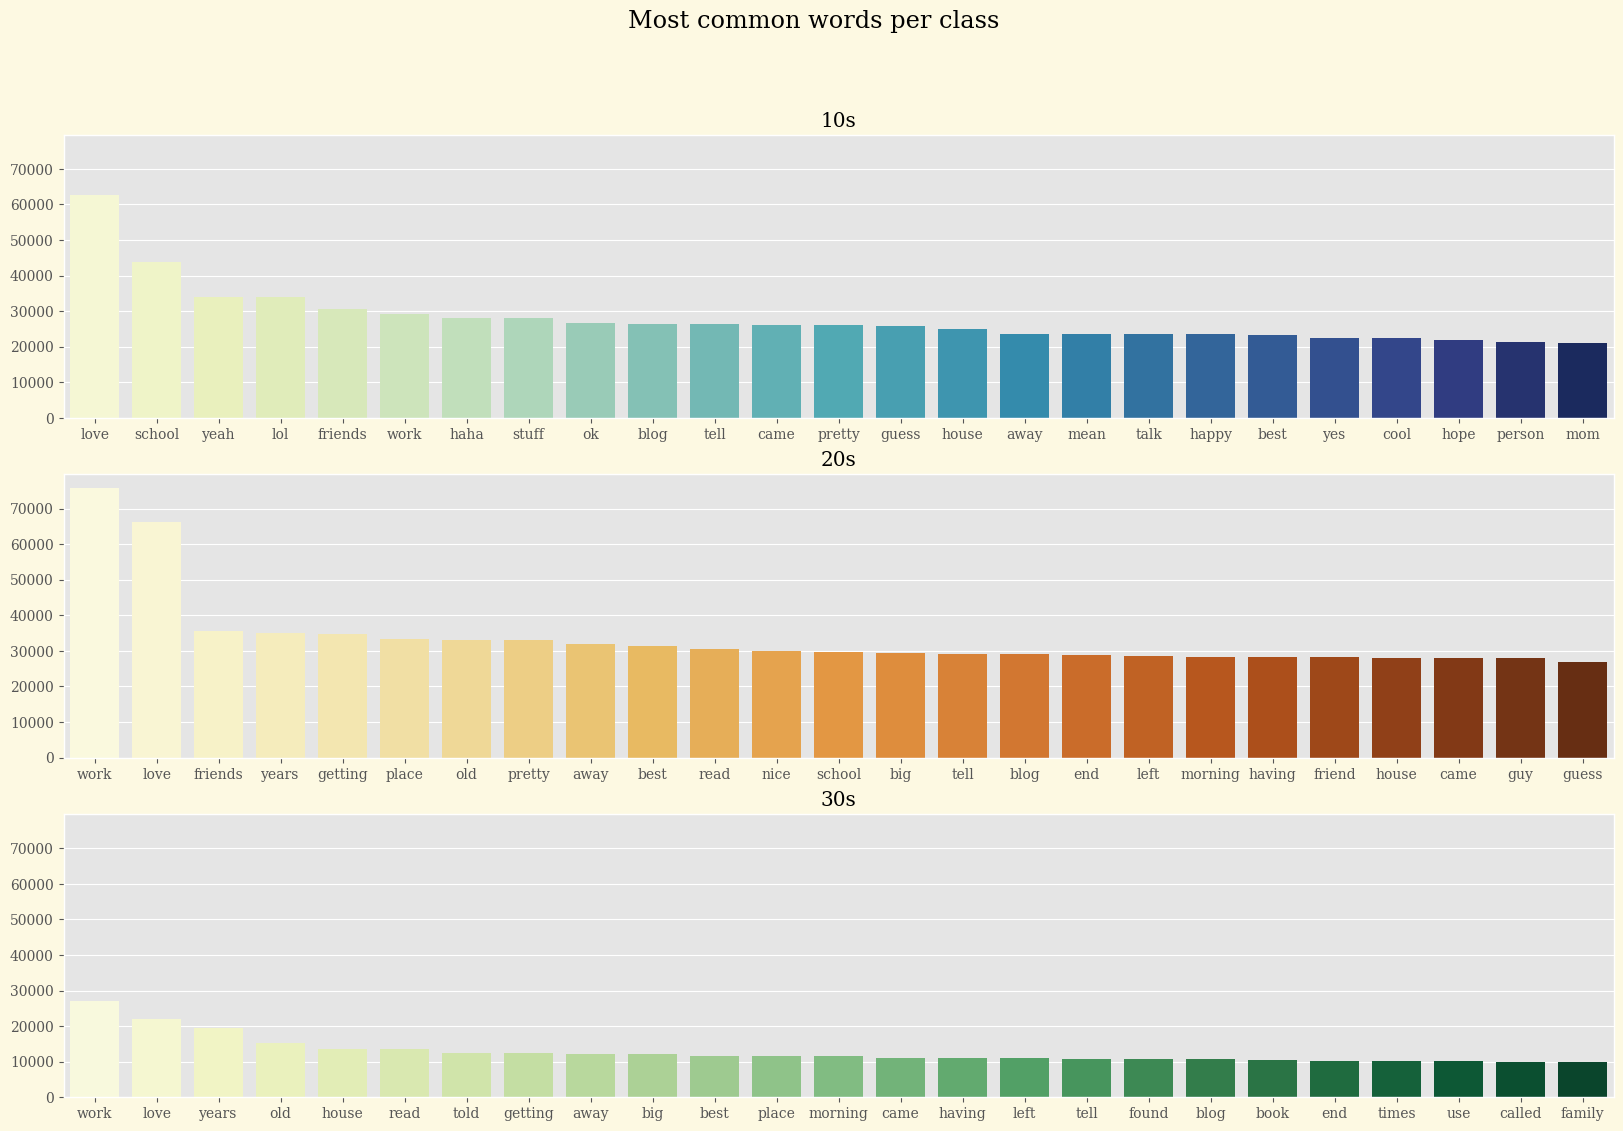

In [49]:
fig,axes = plt.subplots(3,1, sharey=True, figsize=(20,12.5),facecolor='#FDF9E2')
plot_0 = sns.barplot(x = words_0[:25], y = frequency_0[:25], ax=axes[0], palette='YlGnBu').set(title="10s")#,yticklabels = (['0','10k','20k','30k','40k','50k','60k','70k']))
plot_1 = sns.barplot(x = words_1[:25], y = frequency_1[:25], ax=axes[1], palette='YlOrBr').set(title="20s")
plot_2 = sns.barplot(x = words_2[:25], y = frequency_2[:25], ax=axes[2], palette='YlGn').set(title="30s")
fig.suptitle("Most common words per class",fontsize = "xx-large")
plt.tight_layout
plt.savefig("plots/PP_mostCommon_age.png")


In [50]:
corpus = [word for i in train["post"].str.split().values.tolist() for word in i]

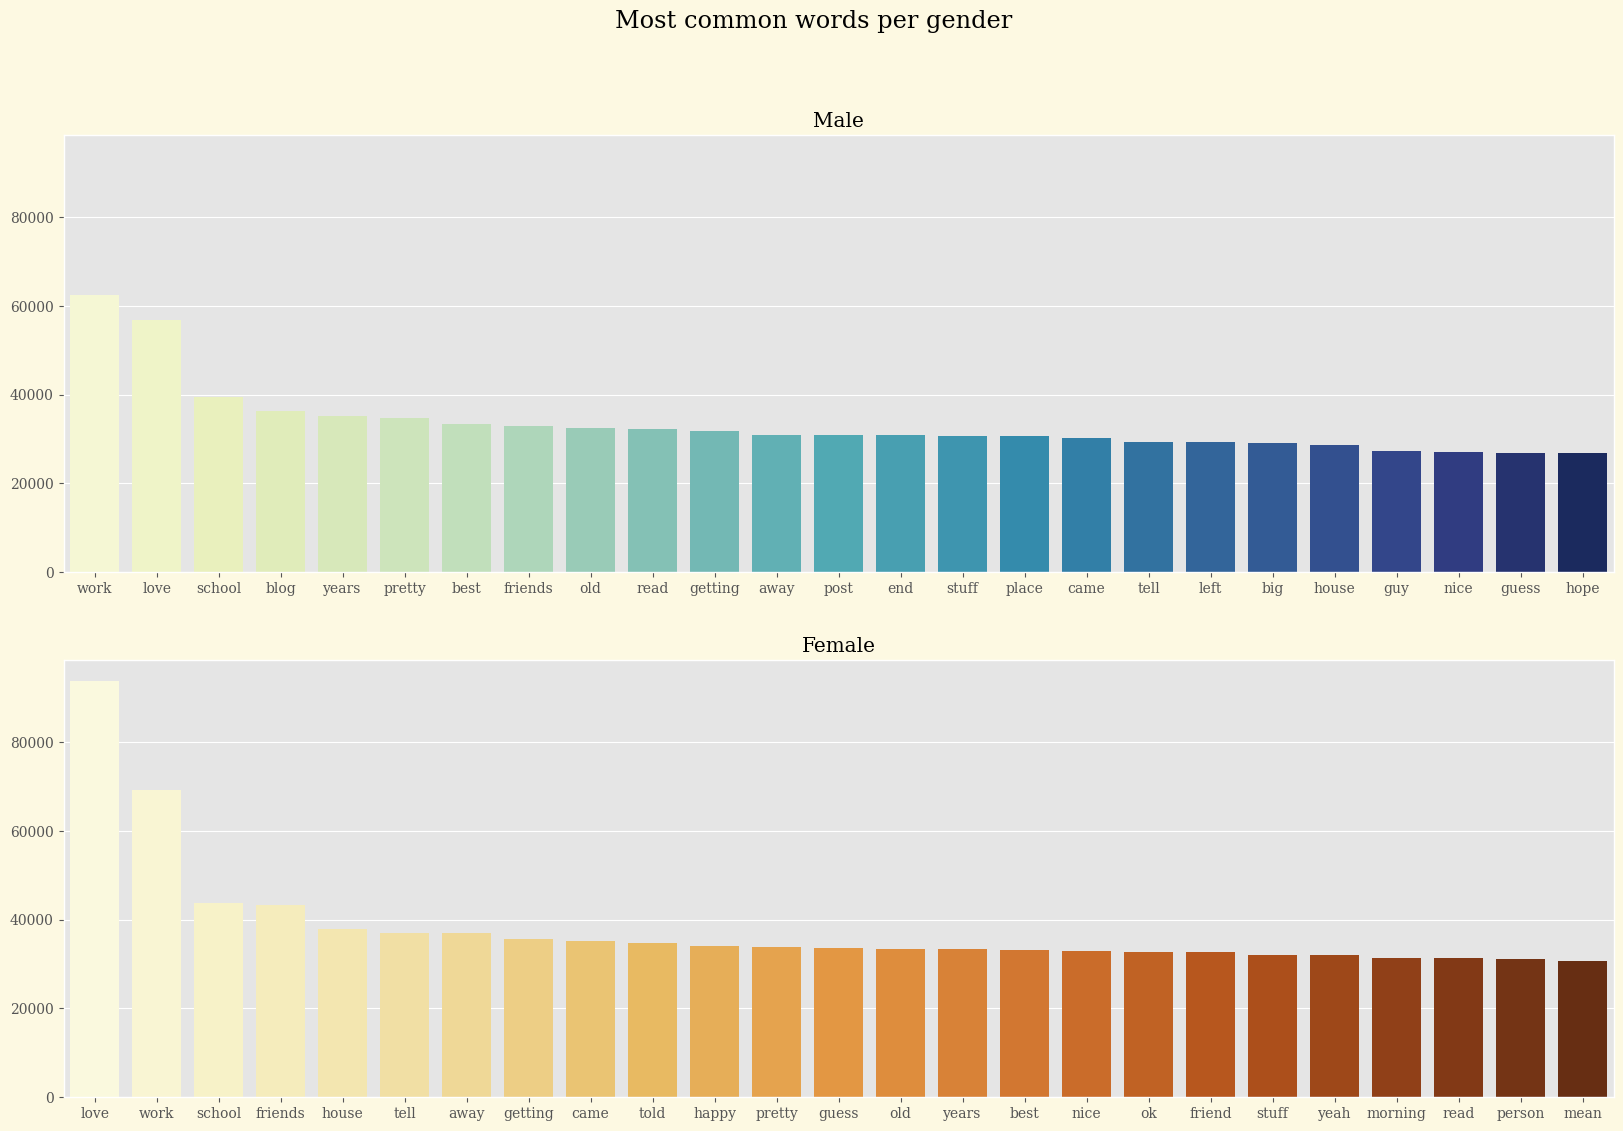

In [51]:
fig,axes = plt.subplots(2,1, sharey=True, figsize=(20,12.5),facecolor='#FDF9E2')
plot_0 = sns.barplot(x = words_m[:25], y = frequency_m[:25], ax=axes[0], palette='YlGnBu').set(title="Male")# ,yticklabels = (['0','25k','50k','75k','100k','125k','150k','175k','200k']))
plot_1 = sns.barplot(x = words_f[:25], y = frequency_f[:25], ax=axes[1], palette='YlOrBr').set(title="Female")
fig.suptitle("Most common words per gender",fontsize = "xx-large")
plt.tight_layout
plt.savefig("plots/PP_mostCommon_gender.png")

In [52]:
bigrams = (pd.Series(nltk.ngrams(corpus, 2)).value_counts())
bigrams_df = bigrams.reset_index()
bigrams_df.columns = ['bigram', 'count']
#1 minutes to run

In [53]:
# Removing the meaningless ones for a better visualization
bigrams_df = bigrams_df.drop(labels=[9,20,26,32,37,38,55])
bigrams_df.head(50)

,bigram,count
0,"(united, states)",15484
1,"(high, school)",11431
2,"(years, ago)",9128
3,"(looking, forward)",6768
4,"(best, friend)",6177
5,"(love, love)",5647
6,"(ice, cream)",5353
7,"(blah, blah)",5174
8,"(years, old)",5090
10,"(brought, quizilla)",4068


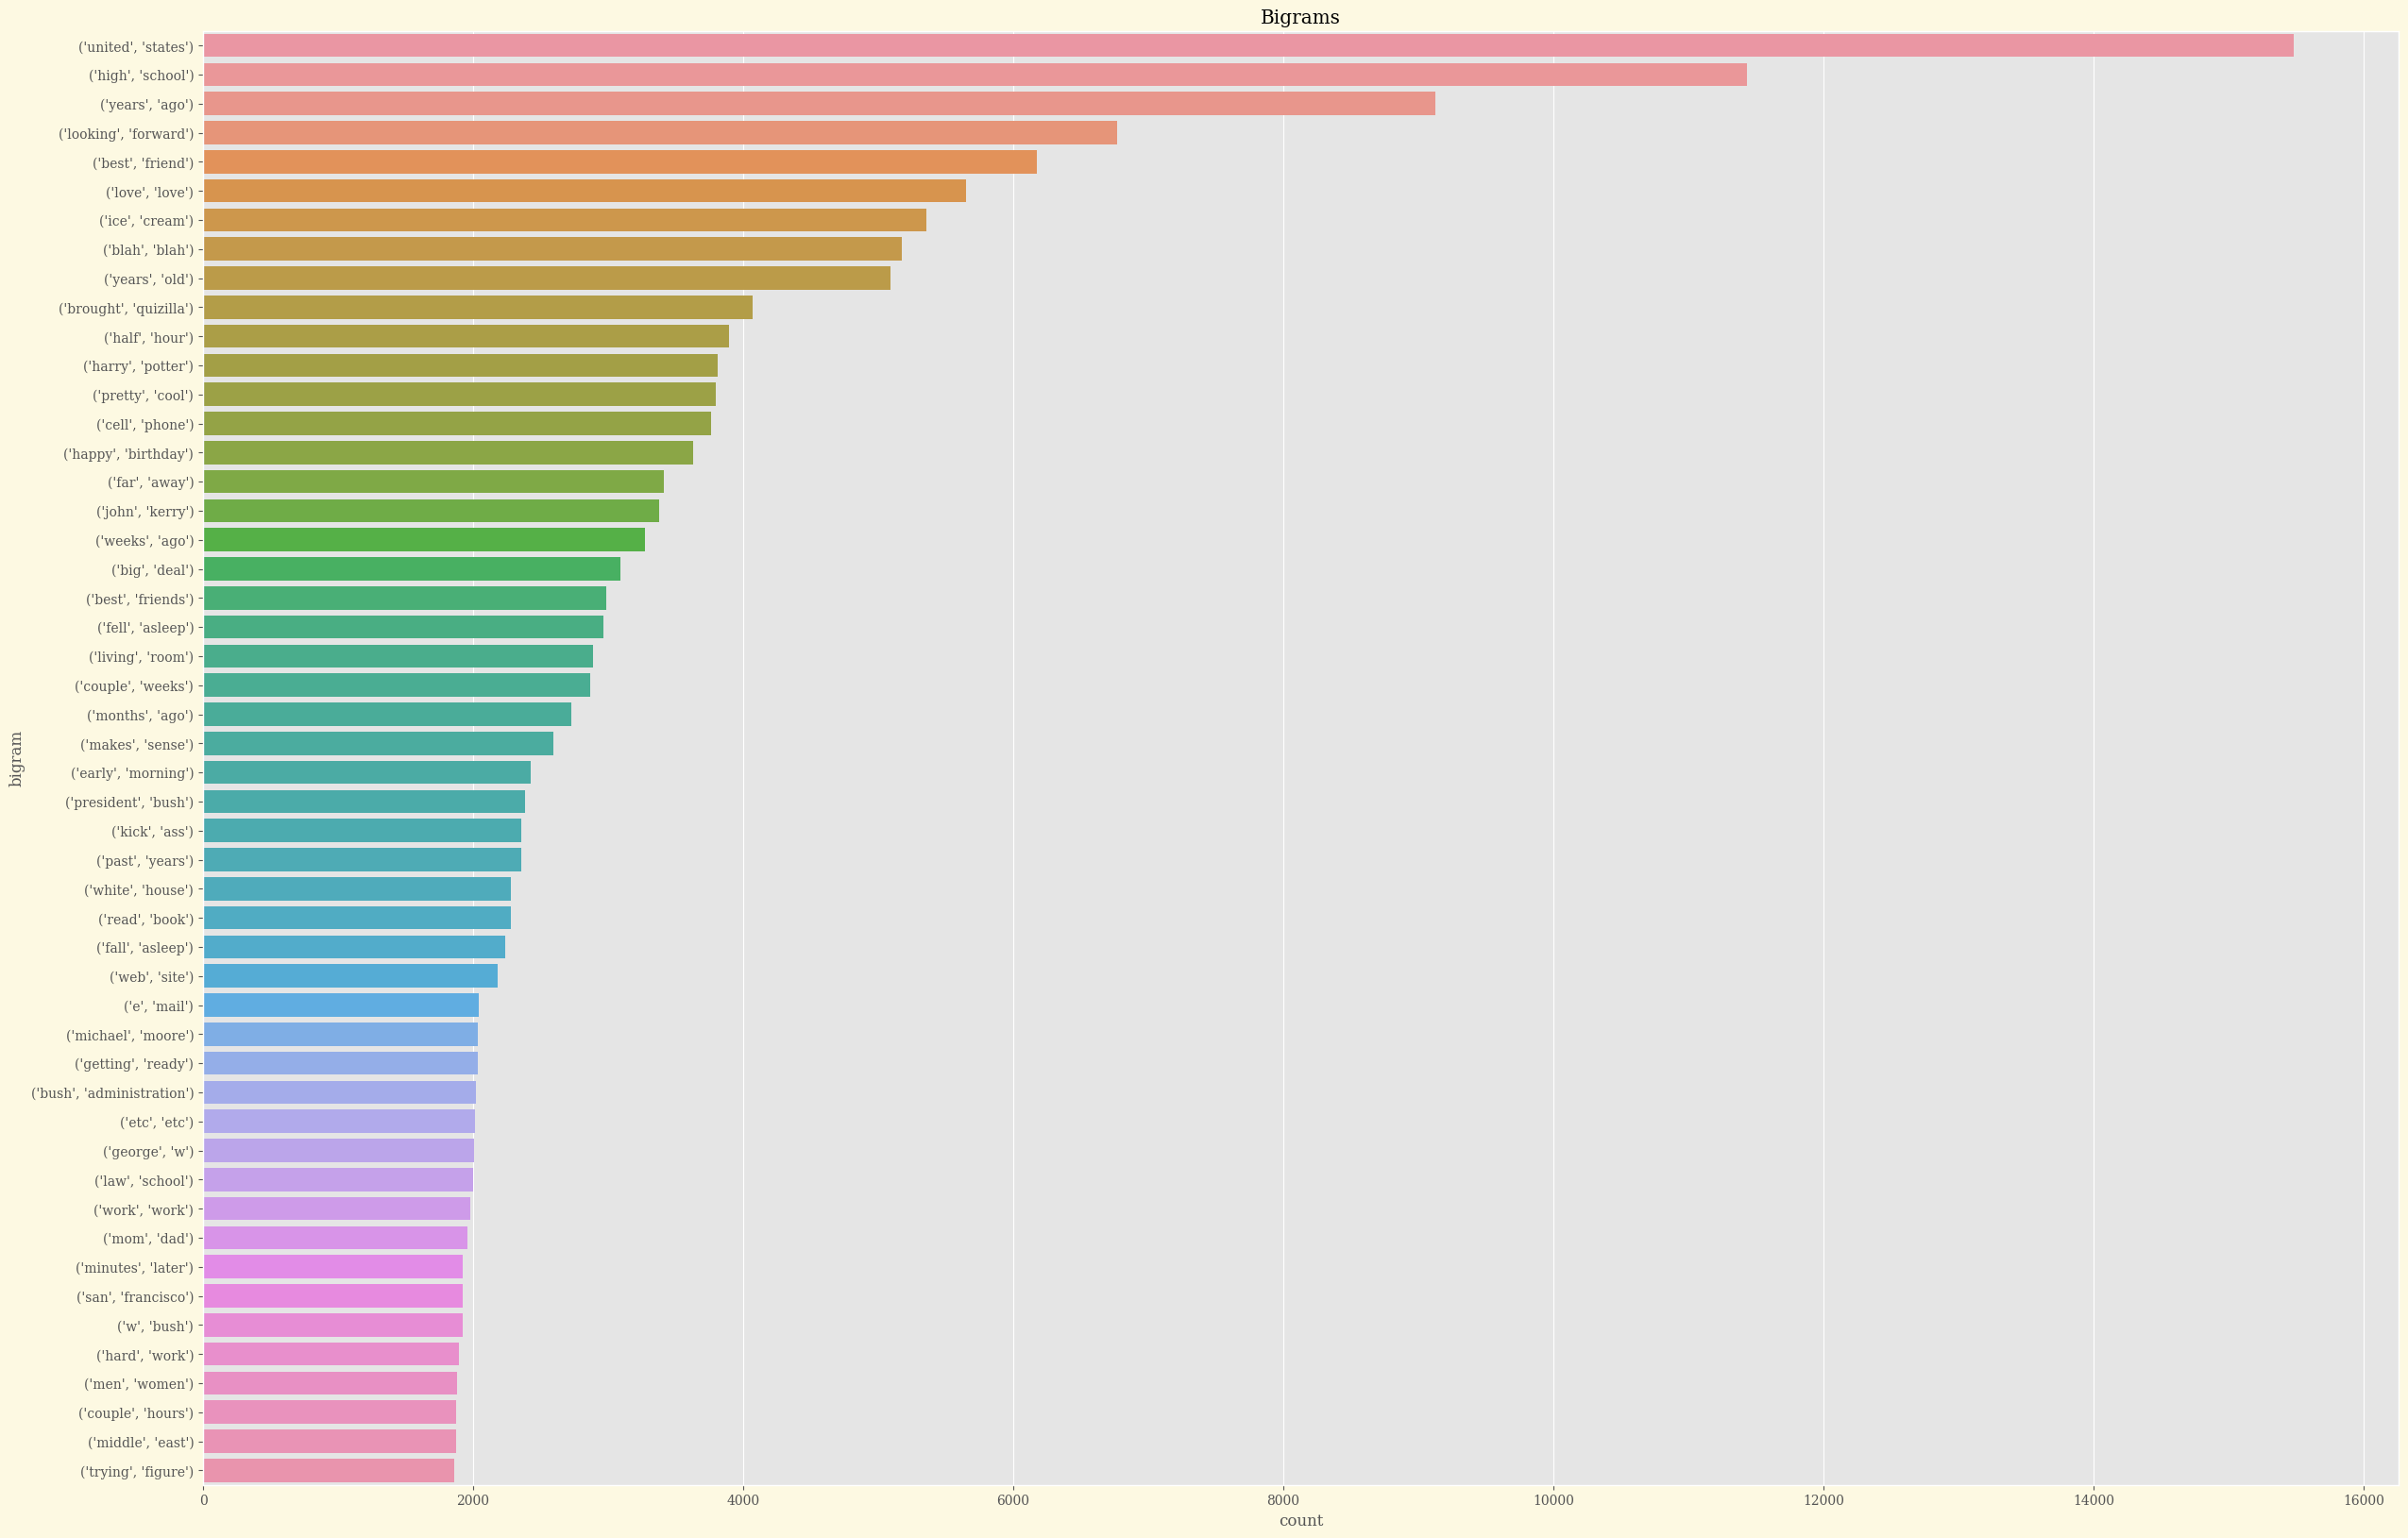

In [54]:
fig, ax = plt.subplots(figsize=(30, 20),facecolor='#FDF9E2')
sns.barplot(bigrams_df.head(50), x = 'count', y = 'bigram',ax=ax ).set(title = "Bigrams")
plt.savefig("plots/PP_bigrams.png")

In [55]:
trigrams = (pd.Series(nltk.ngrams(corpus, 3)).value_counts())
trigrams_df = trigrams.reset_index()
trigrams_df.columns = ['trigram', 'count']
#2 minutes to run

In [56]:
trigrams_df = trigrams_df.drop(axis = 0, index = [3,6,9,10,12,13,14,18,44,52])

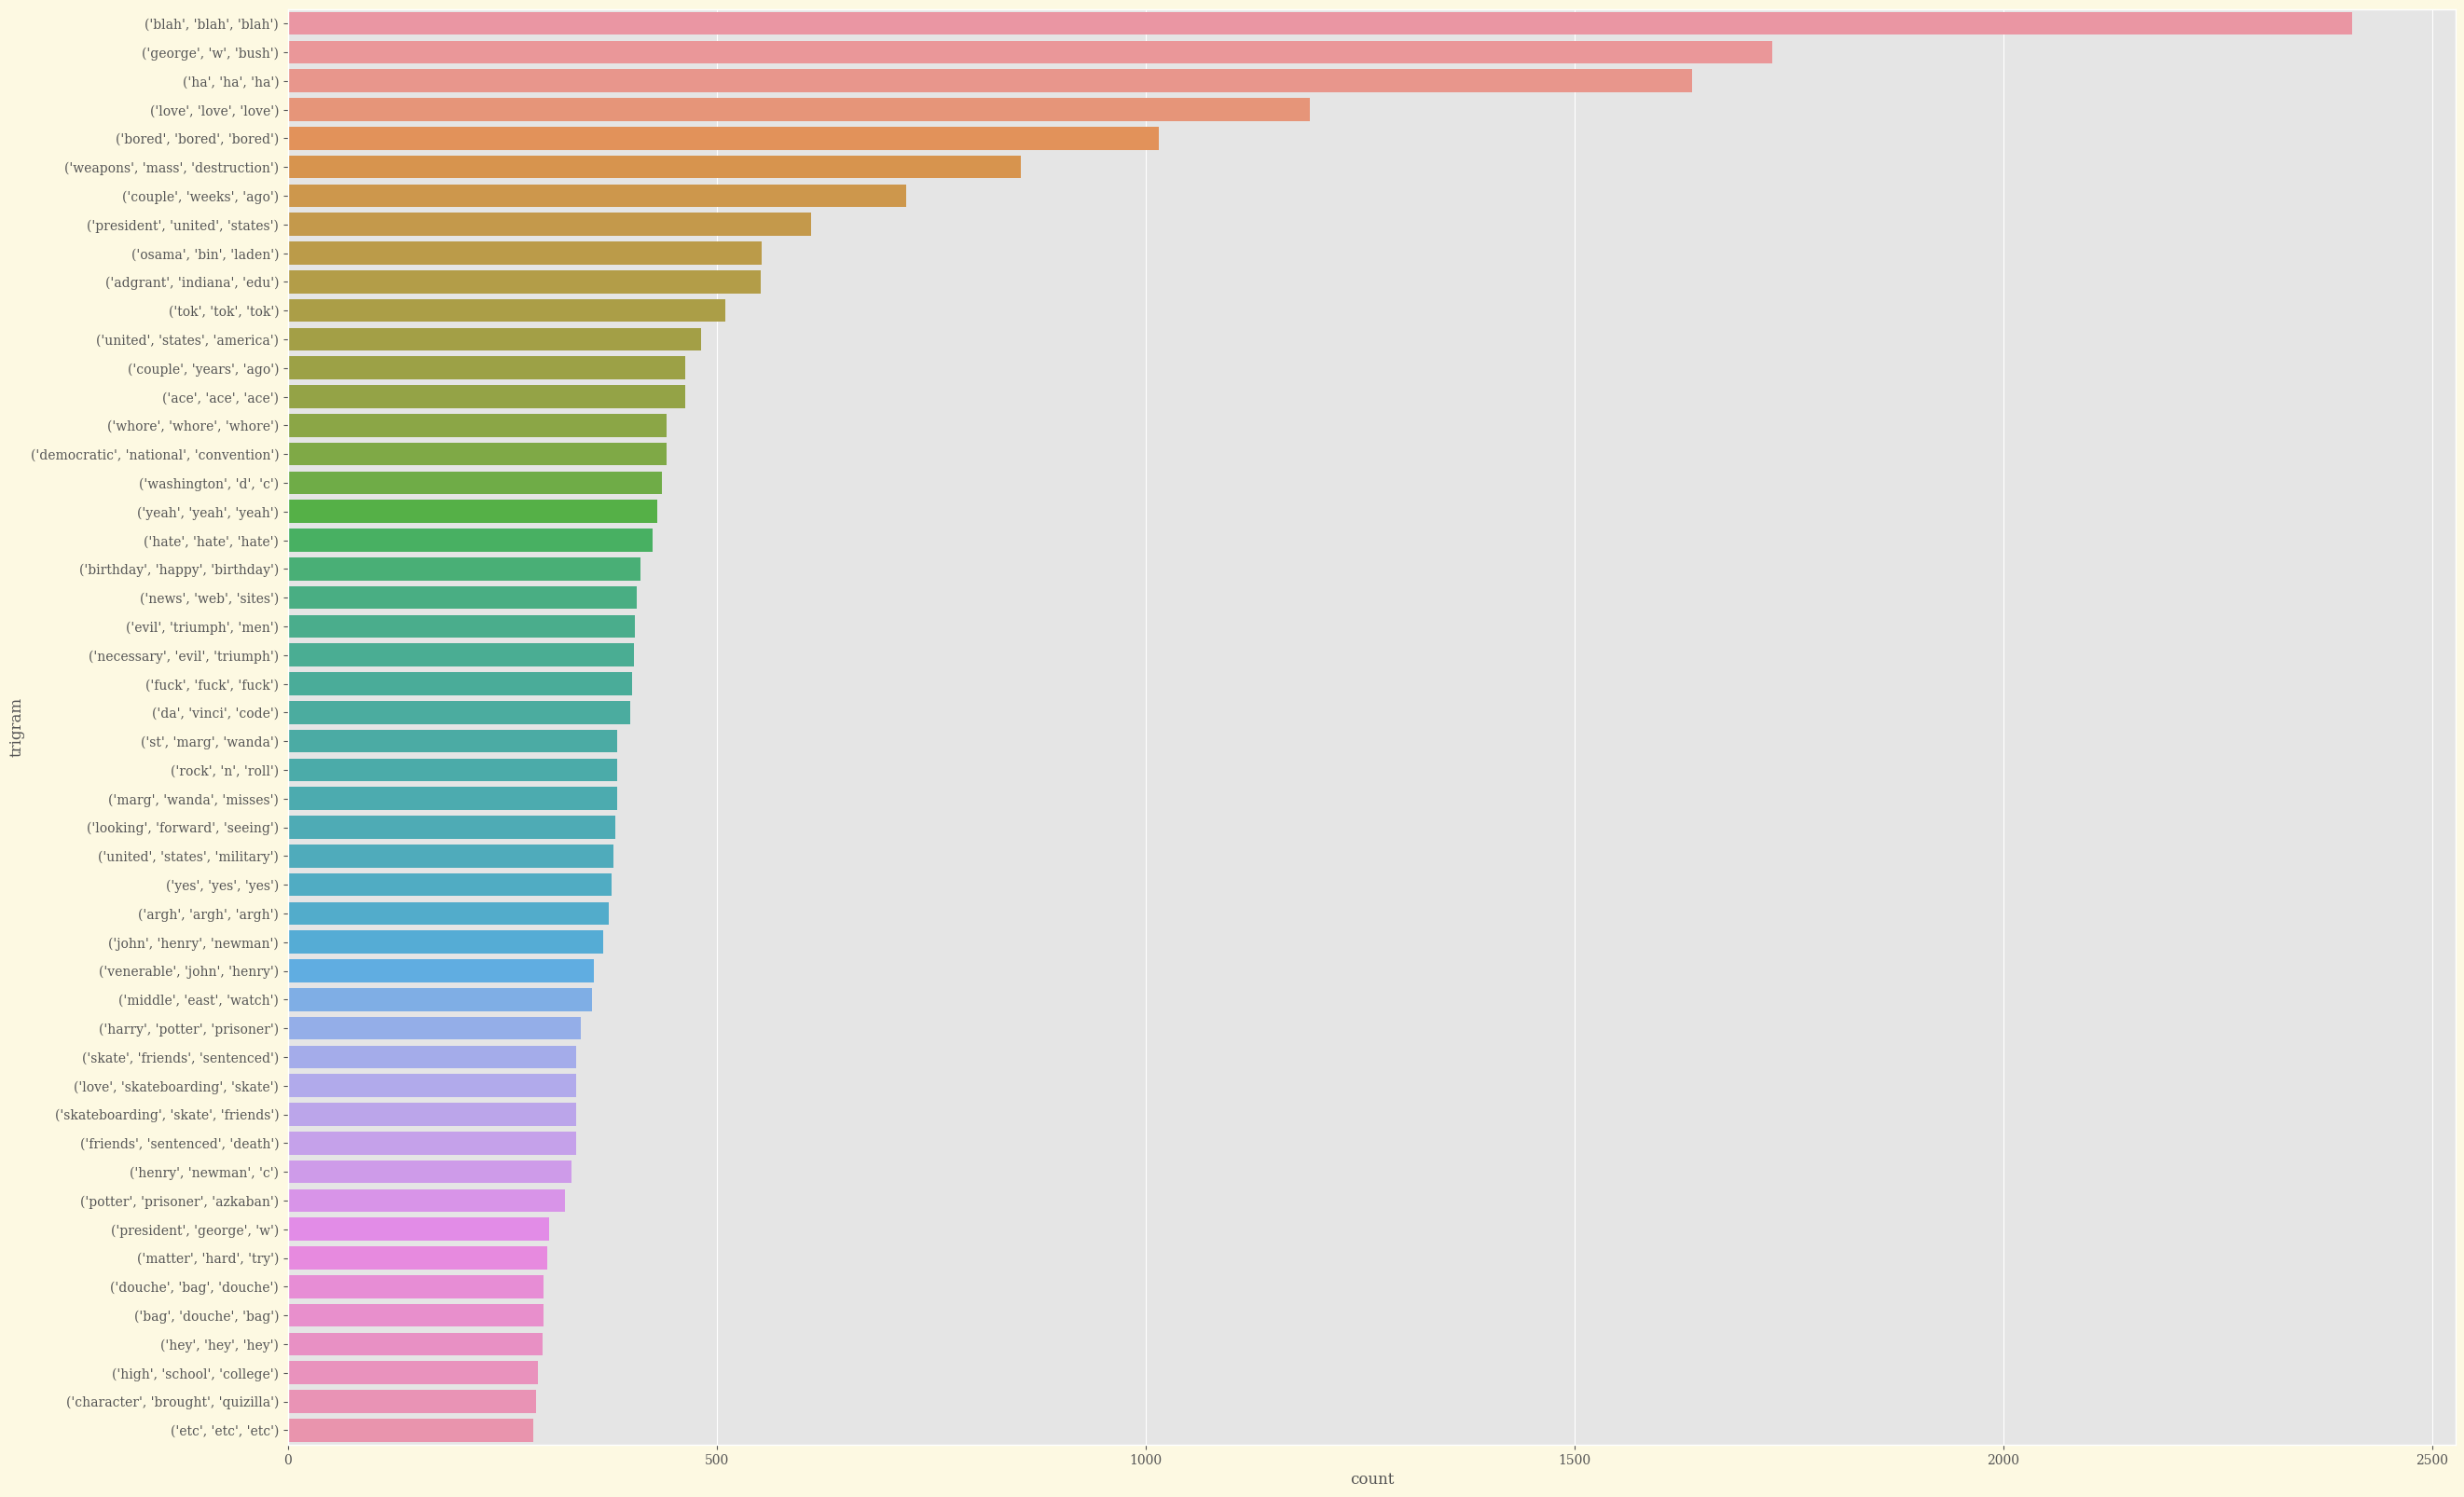

In [57]:
fig, ax = plt.subplots(figsize=(30, 20),facecolor='#FDF9E2')
sns.barplot(trigrams_df.head(50), x = 'count', y = 'trigram', ax = ax)
plt.savefig("plots/PP_trigrams.png")
